# Assignment 1: Power cycles


A simple Brayton cycle consists of three steps:
* Compression
* Heat addition
* Expansion


<!-- ![simple_brayton_cycle](brayton.png) -->

<img src="brayton.png" alt="simple_brayton_cycle" style="width: 600px;"/>


<!-- <br/><br/>

There are ways to increase specific work and/or thermodynamic efficiency.
For example:

![three_type_cycles](./three_type_cycles.svg) -->


## Tasks

Form a team of two students and determine which cycle you have to implemenent with the following formula:

$$N = \textrm{modulo}(\textrm{studentID1} + \textrm{studentID2}, 2) + 1$$

If $N$ is:<br>
$\textbf{1}~...$ **Ideal gas: intercooler + recuperation**<br>
$\textbf{2}~...$ Ideal gas: reheat + recuperation<br>

In our case:
$mod(6453716+6562876 , 2)+1=1$

Use either calorically perfect gas (= ideal gas with constant $\gamma$ and $c_p$) or coolprop. 

**Assumptions:**
* For the intercooled or reheat cycle assume: 
  * that the two stages have equal pressure ratios
  * that the temperature before the second stage is the same as before the first stage
* No pressure losses in combustion chamber: $PR_{cc}=1.0$
* For all compressors use a polytropic efficiency of $\eta_{p,comp}= 0.8$
* For all turbines use polytropic efficiency $\eta_{p,turb} = 0.9$
* For the calculations with ideal gas, assume that the isentropic exponent is constant

**Implement your cycle in this Jupyter Notebook (or matlab) and discuss the following:**
1. Compared to a conventional Brayton cycle with a pressure ratio of 32, how much can the pressure ratio of the new cycle be decreased to reach the same specific work?
2. The thermal efficiency for which cycle is more sensitive to changes in compressor efficiency (explain why)? 
3. Which turbomachinery losses have a greater impact on the performance of the power cycl (explain why)?
4. What are the advantages and disadvantages of the new cycle configuration?

**Hand in:**
* Report (no longer than 5 pages). Use plots from the code below.
* Python (or matlab) functions for the cycle.


## Coolprop

CoolProp is a C++ library that implements several thermodynamic equations of state. http://www.coolprop.org/ 

To Install coolprop use:

 > pip install CoolProp
 
or for directly installing in the jupyter notebook:

 > !pip install CoolProp


In [1]:
!pip install CoolProp

# Note, if struggling might be neccessary to aslo run:
# python -m pip install ipywidgets widgetsnbextension notebook
# from command line and restart the notebook server


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Code


### Brayton cycle, ideal gas (IG) with constant $c_p$

In [ ]:
def Brayton_IG(PR:float, cyc:dict) -> tuple:
    """define ideal gas Brayton cycle performance"""
    # return specific work, efficiency, entropy and temperature at each state point
    
    TR    = cyc['TR'].value       # temperature ratio (tmax/tmin)
    gam_c = cyc['gam_c'].value    # specific heat capacity ratio for compressor 
    gam_t = cyc['gam_t'].value    # specific heat capacity ratio for turbine 
    etap_c = cyc['etap_c'].value  # polytropic eff for compressor
    etap_t = cyc['etap_t'].value  # polytropic eff for turbine
    PR_cc  = cyc['PR_cc'].value   # combustion chamber pressure ratio

    
    # Inputs, gam_c = gamma_air, gam_t = gamma_flg
    T02 = 293.15
    cp_c = R_gas*gam_c/(gam_c-1)
    cp_t = R_gas*gam_t/(gam_t-1)
    
    # Compressor stage 
    TR_c = PR**((gam_c-1)/(gam_c*etap_c)) # Compressor temperature ratio
    T03 = T02*TR_c

    # Combustion 
    T04 = T02*TR

    # Pressure loss in combustion chamber 
    PR_t = PR*PR_cc

    # Turbine stage
    TR_t = (1/PR_t)**(((gam_t-1)/gam_t)*etap_t)
    T05 = TR_t*T04 # Essentially T01?
    
    # Cycle
    w_t = cp_t*(T04-T05)
    w_c = cp_c*(T03-T02)
    h_in = (cp_c+cp_t)/2*(T04-T03)
    eta = (w_t-w_c)/h_in
    specw = (w_t-w_c)/(cp_c*T02) # non-dimensional specific work of the cycle
    
    # Entropy and temperature
    ds_3 = cp_c*np.log(T03/T02) - R_gas*np.log(PR) # compression
    ds_4 = 0.5*(cp_c+cp_t)*np.log(T04/T03) - R_gas*np.log(PR_cc) # heat injection
    ds_5 = cp_t*np.log(T05/T04) - R_gas*np.log(1/PR_t) # expansion
    
    s_2 = 0
    s_3 = ds_3
    s_4 = s_3 + ds_4
    s_5 = s_4 + ds_5
    
    # Concatenate tuples
    entr = [s_2, s_3, s_4, s_5, s_2] # s_2 = 0, reference!
    temp = [T02, T03, T04, T05, T02]
    
    return specw, eta, entr, temp

### Brayton cycle with CoolProp, real gas (RG)

In [3]:
def Brayton_RG(PR, cyc):
    
    TR    = cyc['TR'].value       # temperature ratio (tmax/tmin)
    etap_c = cyc['etap_c'].value  # polytropic eff for compressor
    etap_t = cyc['etap_t'].value  # polytropic eff for turbine
    
    fl = "air"

    # compressor inlet 
    T02 = 293.15
    P02 = 1.0e5
    h02  = cp.PropsSI('H', 'T', T02, 'P', P02, fl)
    s02  = cp.PropsSI('S', 'T', T02, 'P', P02, fl)
    
    # compressor outlet / combustion chamber inlet
    P03  = P02 * PR
    s03s = s02 
    h03s = cp.PropsSI('H', 'P', P03, 'S', s03s, fl)
    h03  = h02 + (h03s-h02)/etap_c
    T03  = cp.PropsSI('T', 'P', P03, 'H', h03, fl)
    s03  = cp.PropsSI('S', 'P', P03, 'H', h03, fl)

    # combustion chamber outlet / turbine inlet
    P04  = P03
    T04  = T02 * TR
    h04  = cp.PropsSI('H', 'T', T04, 'P', P04, fl)
    s04  = cp.PropsSI('S', 'T', T04, 'P', P04, fl)

    # turbine outlet
    P05  = P02
    s05s = s04
    h05s = cp.PropsSI('H', 'P', P05, 'S', s05s, fl)
    h05  = h04 - (h04-h05s)*etap_t
    T05  = cp.PropsSI('T', 'H', h05, 'P', P05, fl)
    s05  = cp.PropsSI('S', 'T', T05, 'P', P05, fl)

    # Cycle
    w_t = h04-h05   # cp_t*(T04-T05)
    w_c = h03-h02   # cp_c*(T03-T02)
    hin = h04-h03   # (cp_c+cp_t)/2*(T04-T03)
    eta = (w_t-w_c)/hin
    specw = (w_t-w_c)/h02 #(cp_c*T02)
        
    # Concatenate tuples
    entr = [0, s03-s02, s04-s02, s05-s02, 0.0] # s_2 = 0 is reference!
    temp = [T02, T03, T04, T05, T02]
    
    return specw, eta, entr, temp

### Recuperated Brayton cycle, ideal gas (IG)

In [4]:
def BraytonRecup_IG(PR, cyc):
    
#     PR    = cyc['PR'].value       # pressure ratio
    TR    = cyc['TR'].value       # temperature ratio (tmax/tmin)
    gam_c = cyc['gam_c'].value    # specific heat capacity ratio for compressor 
    gam_t = cyc['gam_t'].value    # specific heat capacity ratio for turbine 
    etap_c = cyc['etap_c'].value  # polytropic eff for compressor
    etap_t = cyc['etap_t'].value  # polytropic eff for turbine
    PR_cc  = cyc['PR_cc'].value   # combustion chamber pressure ratio
    
    # Inputs, gam_c = gamma_air, gam_t = gamma_flg
    T02 = 293.15
    cp_c = R_gas*gam_c/(gam_c-1)
    cp_t = R_gas*gam_t/(gam_t-1)
    
    # Compressor stage 
    TR_c = PR**((gam_c-1)/gam_c/etap_c)
    T03 = T02*TR_c

    # Combustion stage
    T04 = T02*TR

    # Stuff for pressure loss 
    PR_t = PR*PR_cc

    # Turbine stage
    TRt = (1/PR_t)**((gam_t-1)/gam_t*etap_t)
    T05 = TRt*T04
    
    # Cycle
    w_t = cp_t*(T04-T05)
    w_c = cp_c*(T03-T02)
    if T05 > T03:
        hin = (cp_c+cp_t)/2*(T04-T05)
    else:
        hin = (cp_c+cp_t)/2*(T04-T03)
        
    eta = (w_t-w_c)/hin
    specw = (w_t-w_c)/(cp_c*T02)
    
    # Entropy and temperature
    ds_3 = cp_c*np.log(T03/T02) - R_gas*np.log(PR) # compression
    ds_4 = 0.5*(cp_c+cp_t)*np.log(T04/T03) - R_gas*np.log(PR_cc) # heat injection
    ds_5 = cp_t*np.log(T05/T04) - R_gas*np.log(1/PR_t) # expansion
    
    s_2 = 0
    s_3 = ds_3
    s_4 = s_3 + ds_4
    s_5 = s_4 + ds_5
    
    # Concatenate tuples
    entr = [s_2, s_3, s_4, s_5, s_2] # s_2 = 0, reference!
    temp = [T02, T03, T04, T05, T02]
    
    return specw, eta, entr, temp

### Your cycle calculation

In [10]:
def YOUR_ASSIGNEMNT(PR, cyc):

    #########
    # Brayton cycle with intercooling + recuperation
    #########
    
#     PR    = cyc['PR'].value       # pressure ratio
    TR    = cyc['TR'].value       # temperature ratio (tmax/tmin)
    gam_c = cyc['gam_c'].value    # specific heat capacity ratio for compressor 
    gam_t = cyc['gam_t'].value    # specific heat capacity ratio for turbine 
    etap_c = cyc['etap_c'].value  # polytropic eff for compressor
    etap_t = cyc['etap_t'].value  # polytropic eff for turbine
    PR_cc  = cyc['PR_cc'].value   # combustion chamber pressure ratio

    # TODO: Experiment with intercooler and recuperator efficiency values
    
    # Inputs, gam_c = gamma_air, gam_t = gamma_flg
    T02 = 293.15
    cp_c = R_gas*gam_c/(gam_c-1)
    cp_t = R_gas*gam_t/(gam_t-1)


    #------------------------------
    # code your model here:
    
    # LPC
    #   Isentropic compression

    # We want both our compressor stages to have the same pressure ratio
    PR_c1 = PR**0.5 
    # TODO: Assume two efficiencies for the two compressor stages. Argue why
    TR_c1 = PR_c1**((gam_c-1)/(gam_c*etap_c)) # Compressor 1 temperature ratio
    T03 = T02*TR_c1
    
    # Intercooler stage - Isobaric cooling
        # intercooler efficiency
            # Let us define the intercooler efficiency as how close to T02 we cool
    etap_ic = 0.95 # Magic number (input parameter)

    T04 = T02 + etap_ic * (T03 - T02) # Ideal intercooler cools back to T02
    
    # Combustion stage
    T05 = T02*TR

    # Pressure loss in combustion chamber
    PR_t = PR*PR_cc

    # Turbine stage
    TR_t = (1/PR_t)**(((gam_t-1)/gam_t)*etap_t)
    T06 = TR_t*T05

    # Cycle
    w_t = cp_t*(T05-T06)
    w_c1 = cp_c*(T03-T02)
    w_c2 = cp_c*(T04-T02)
    w_c = w_c1 + w_c2
    # Recuperator stage - Isobaric heat exchange
        # recuperator efficiency
            # Let us define the recuperator efficiency as how close to T06 we heat
    etap_recup = 0.75 # Magic number (input parameter)
    T07 = T04 + etap_recup * (T06 - T04)
    if T06 > T07:
        hin = (cp_c+cp_t)/2*(T05-T07)
    else:
        hin = (cp_c+cp_t)/2*(T05-T04)

    eta = (w_t-w_c)/hin
    specw = (w_t-w_c)/(cp_c*T02)

    # Entropy and temperature
    ds_3 = cp_c*np.log(T03/T02) - R_gas*np.log(PR_c1) # compression 1
    ds_4 = cp_c*np.log(T04/T03) # intercooling
    ds_5 = 0.5*(cp_c+cp_t)*np.log(T05/T04) - R_gas*np.log(PR_cc) # heat injection
    ds_6 = cp_t*np.log(T06/T05) - R_gas*np.log(1/PR_t) # expansion
    ds_7 = cp_c*np.log(T07/T04) # recuperation
    
    s_2 = 0
    s_3 = ds_3
    s_4 = s_3 + ds_4
    s_5 = s_4 + ds_5
    s_6 = s_5 + ds_6
    s_7 = s_4 + ds_7
    
    # Concatenate tuples
    entr = [s_2, s_3, s_4, s_5, s_6, s_7, s_2] # s_2 = 0, reference!
    temp = [T02, T03, T04, T05, T06, T07, T02]
    
    return specw, eta, entr, temp

# Compare and plot

In [6]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, interact_manual, interactive_output, Label
import numpy as np
from matplotlib import pyplot as plt

# this only works in jupyter notebooks (remove it otherwise)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc, rcParams
rcParams.update({'font.size': 12})

# import coolprop. to install coolprop use "pip install CoolProp" in a terminal or directly here using: 
# !pip install CoolProp   # uncomment this line to install CoolProp here.
import CoolProp.CoolProp as cp

Output()

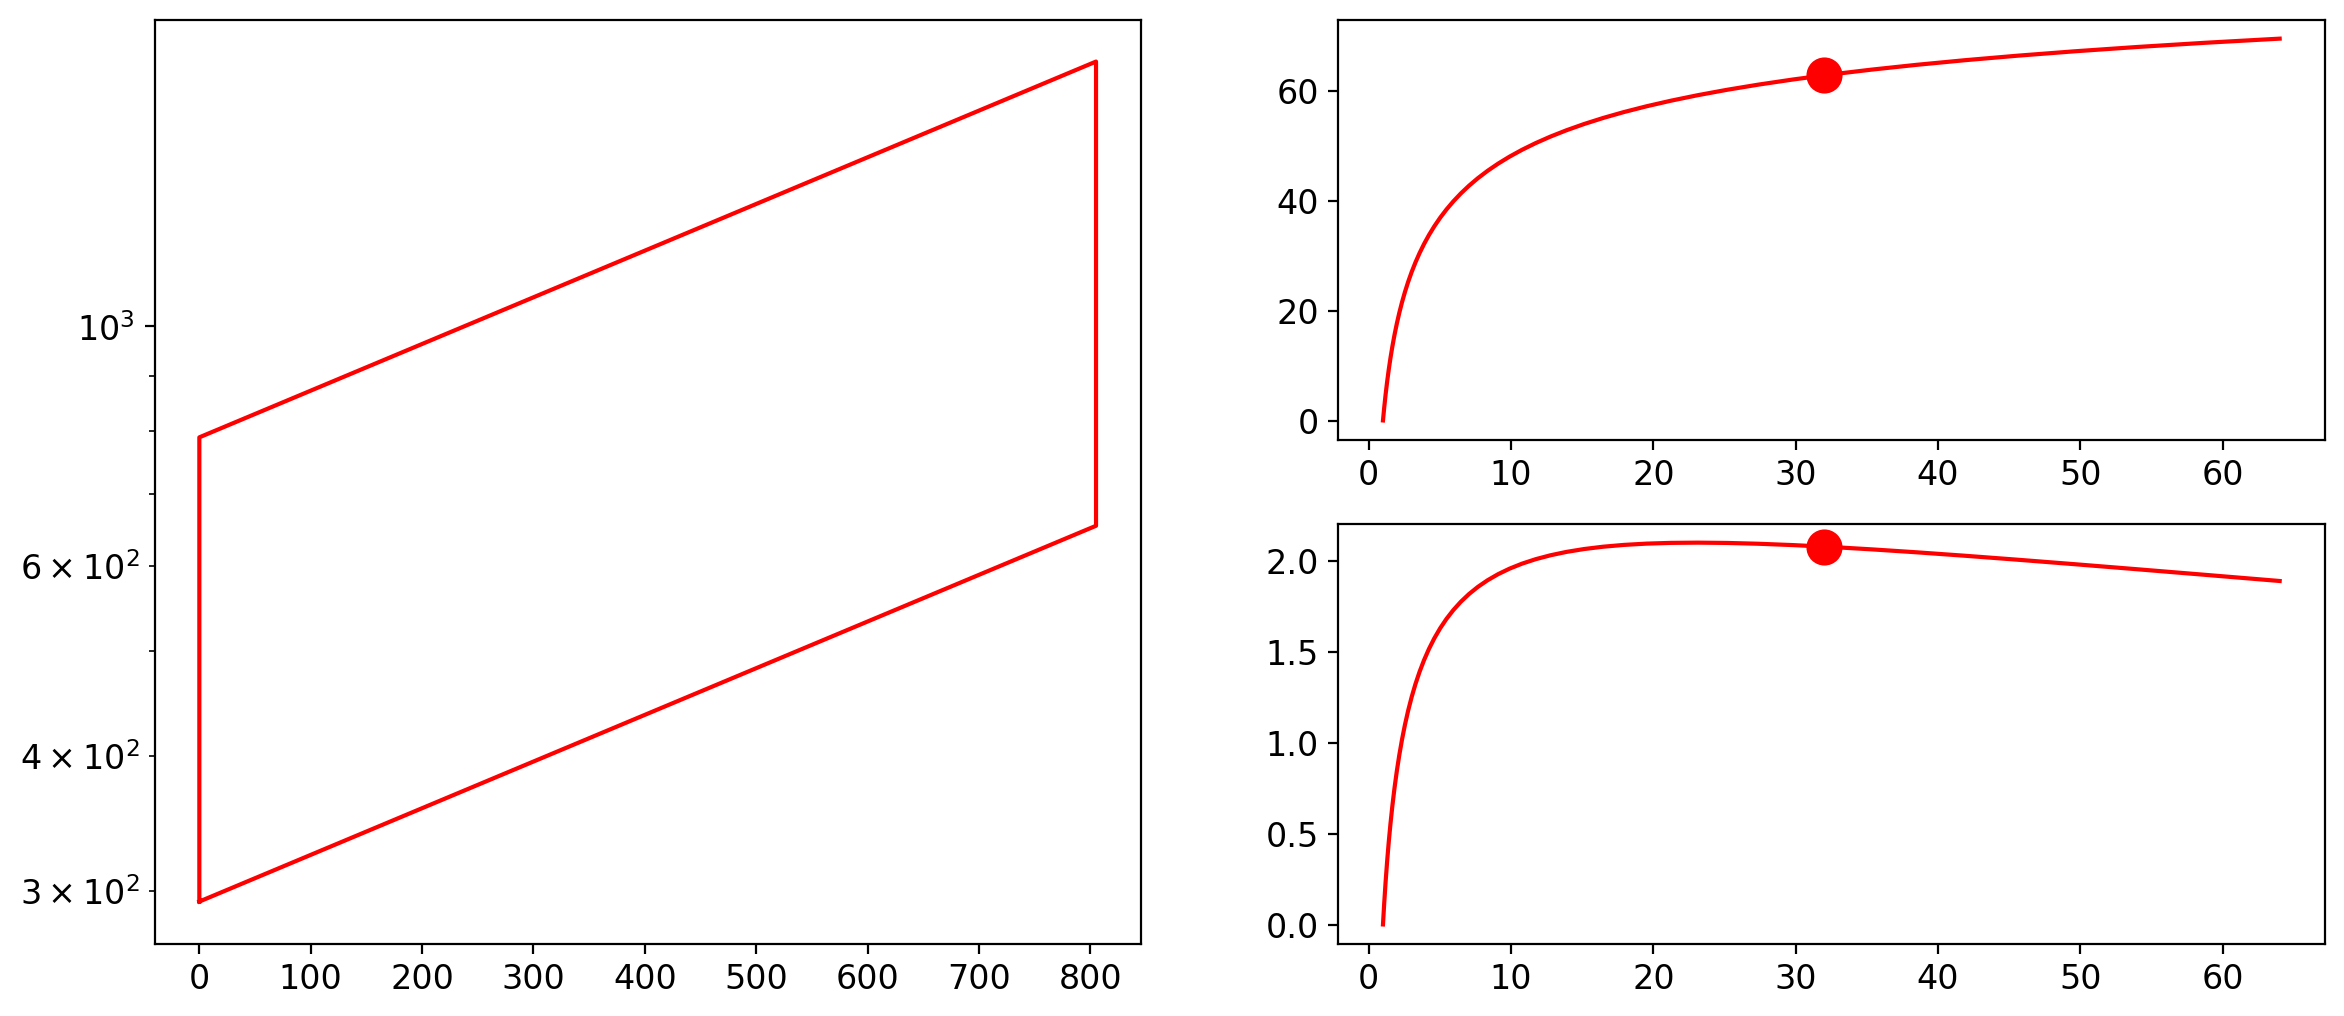

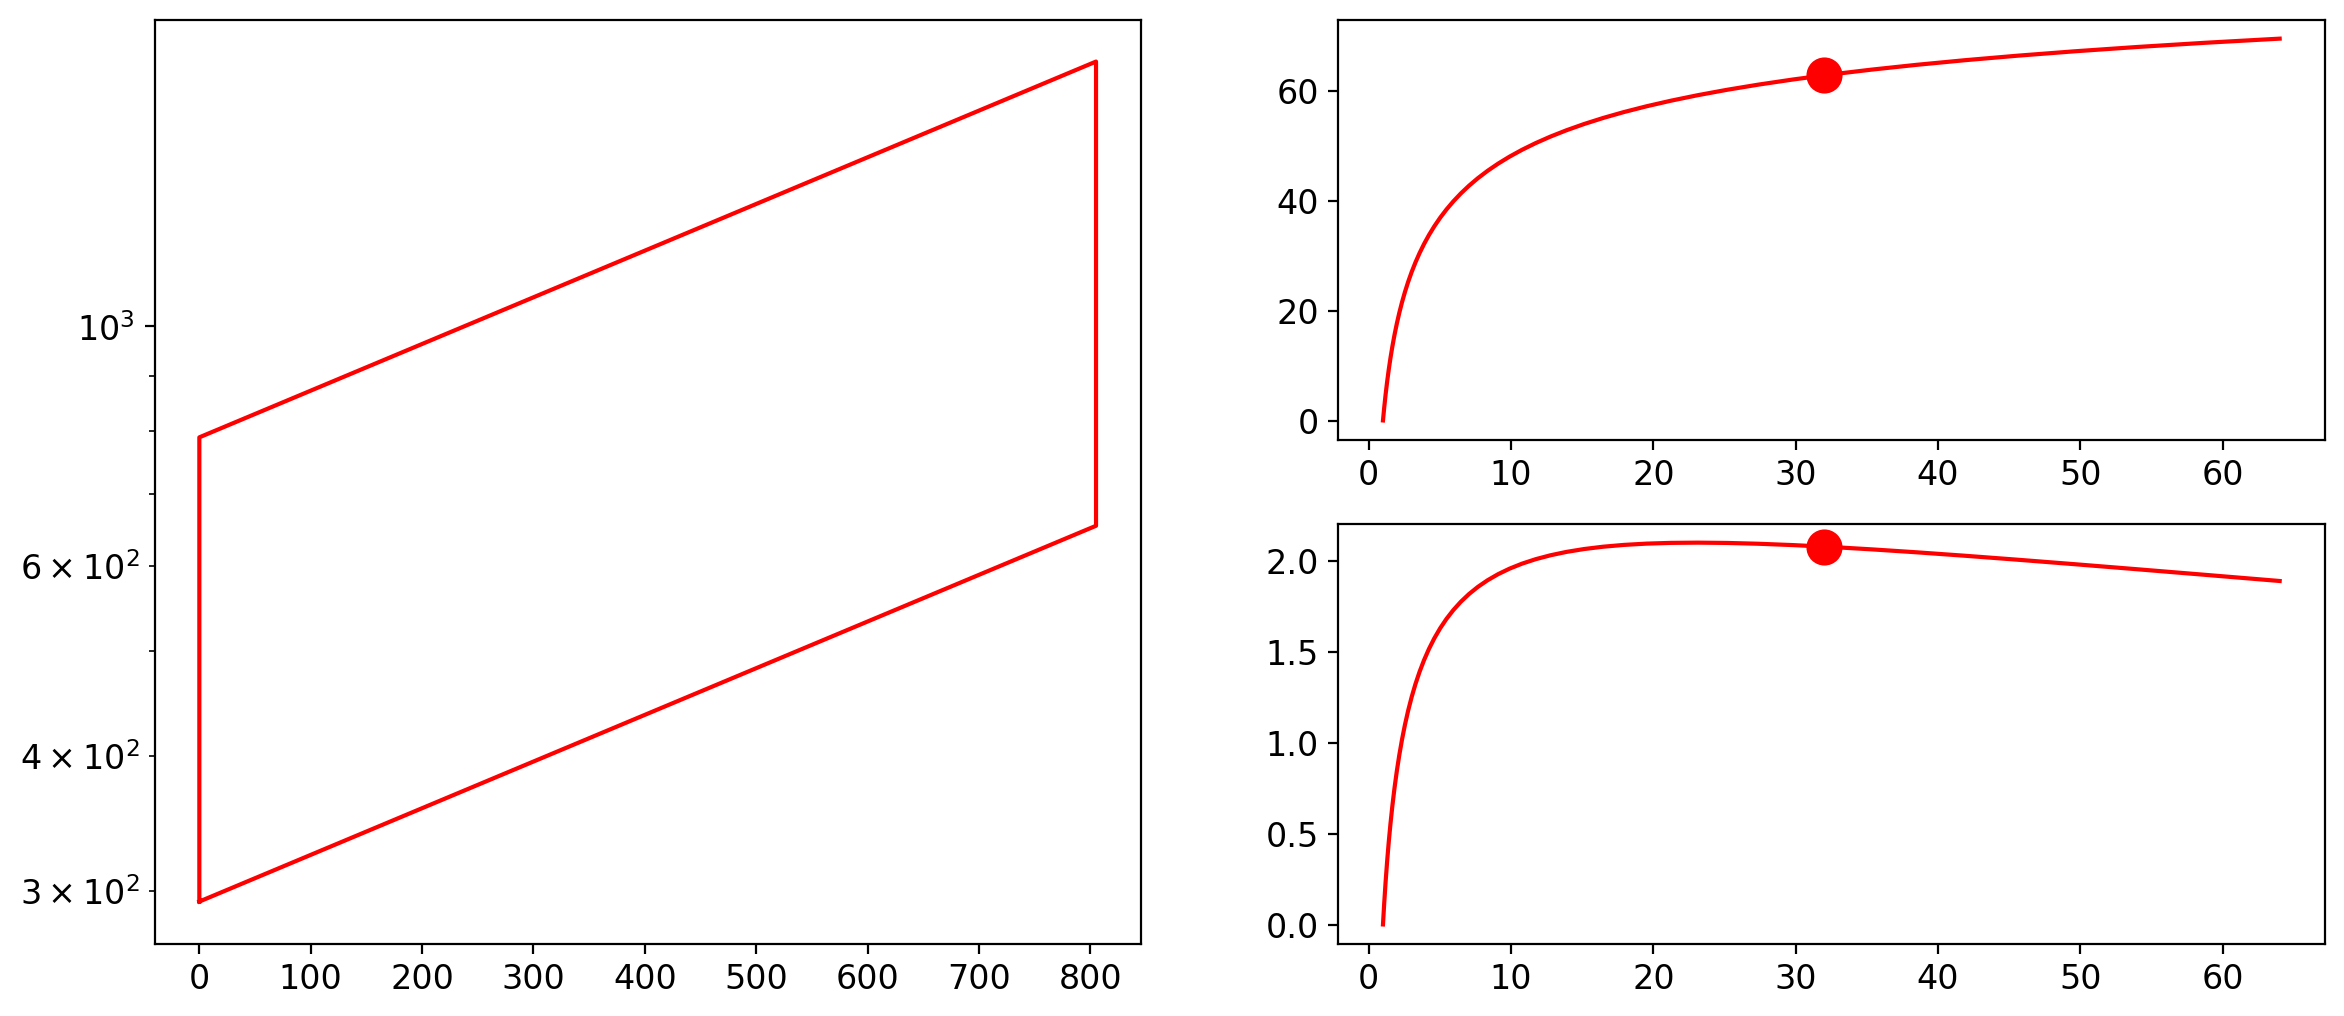

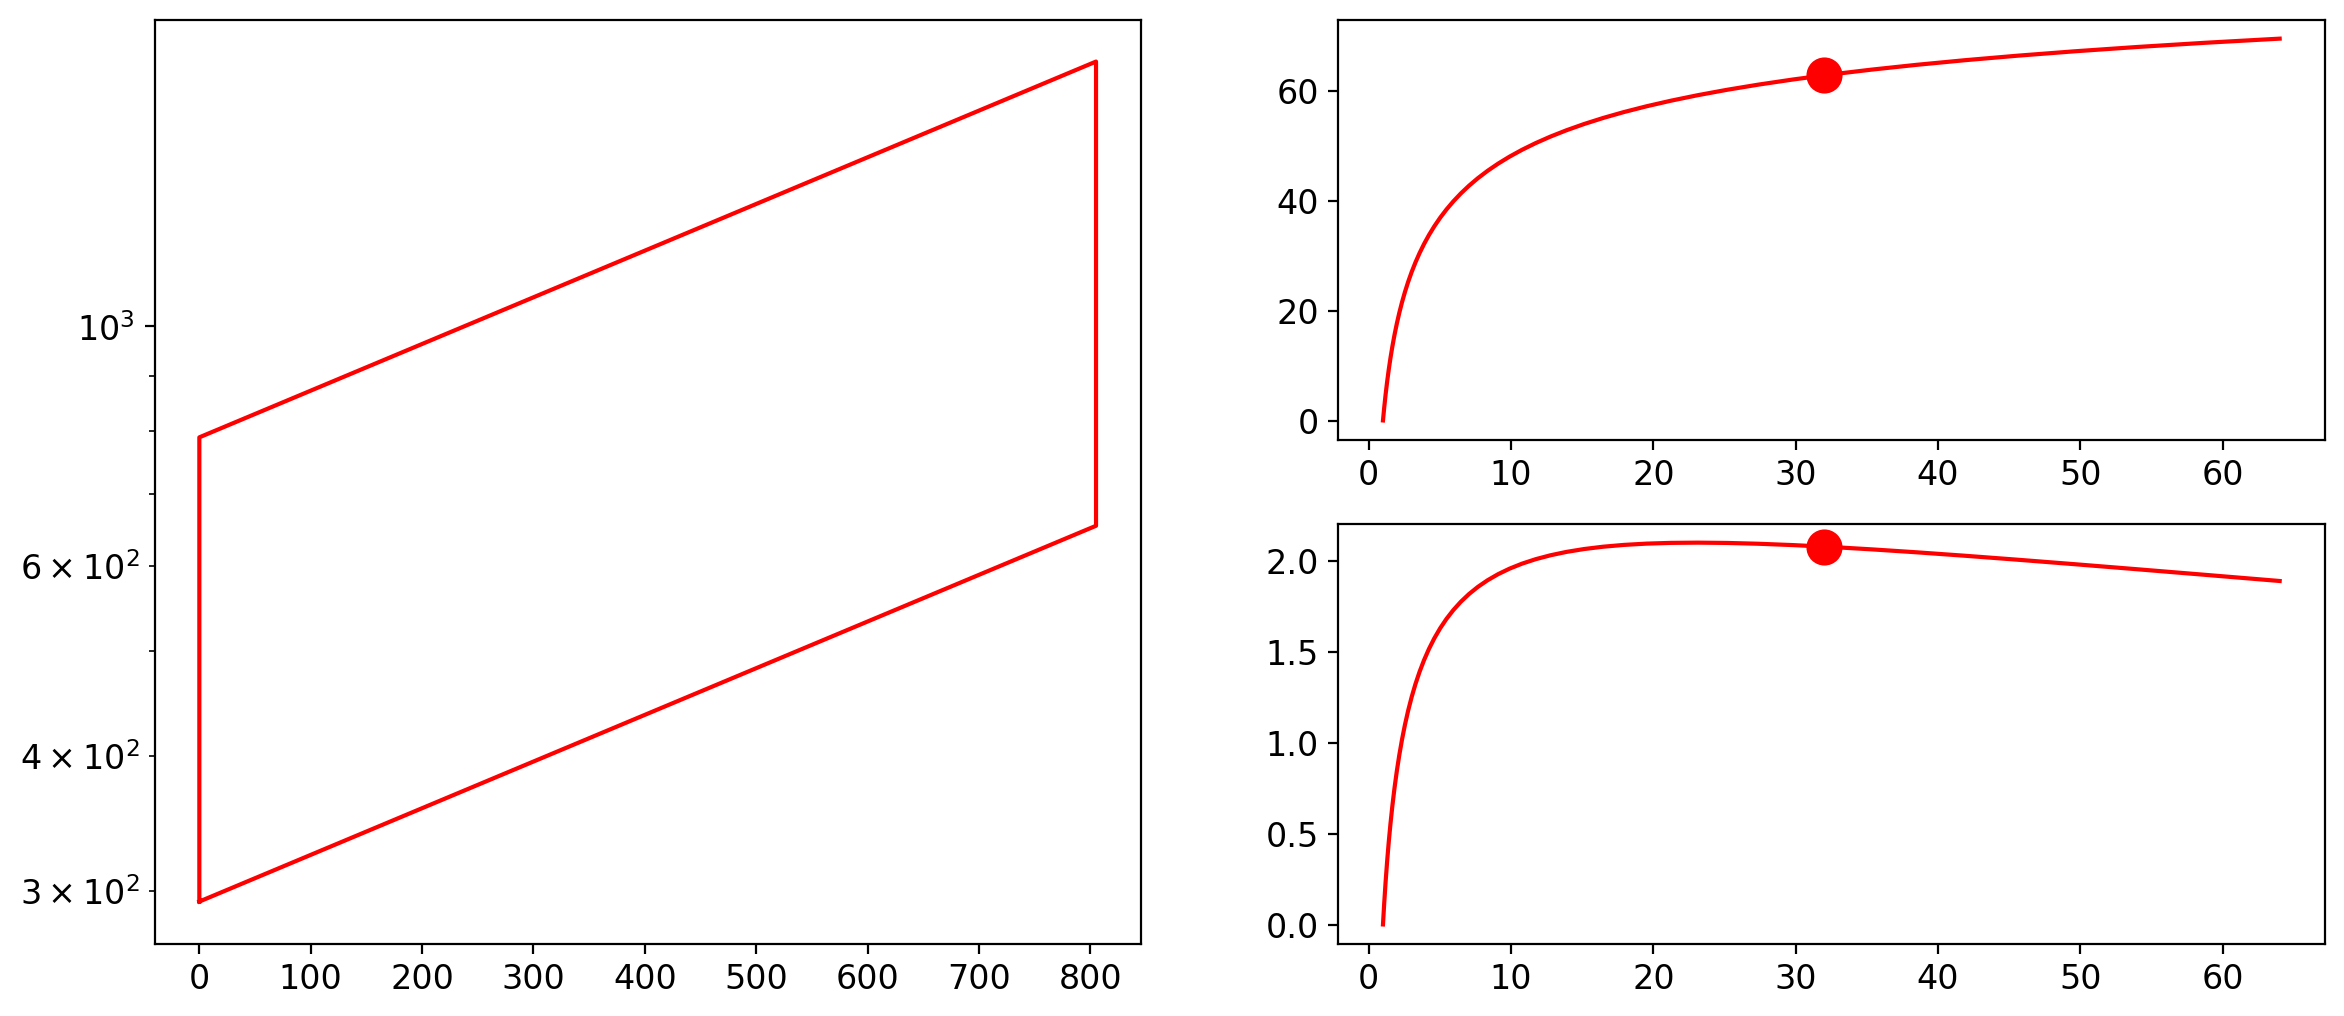

In [8]:
R_gas = 287.0

# Define colors for the cycles. Note, number of defined colors is also number of cycles to compare 
colors = ['red','blue']           # two cycles
# colors = ['red','blue', 'green']  # three cycles

# dictionary of available cycle functions, add new functions if necessary 
functions = { 'Brayton_IG':      Brayton_IG, 
              'Brayton_RG':      Brayton_RG, 
              'BraytonRecup_IG': BraytonRecup_IG, 
              'YOUR_ASSIGNEMNT': YOUR_ASSIGNEMNT }

# define a dictionary for cycle parameters
cycle  = {}

# make a list of cycles depending on how many colors have been defined
cycles = [cycle.copy() for i in colors]

# function to plot T-s d
def plotResult(update):
    with out:
        out.clear_output(wait=True)
        
        fig  = plt.figure(figsize=(14,6))
        grid = fig.add_gridspec(2, 2)
        ax   = [fig.add_subplot(grid[:, 0]), fig.add_subplot(grid[0, 1]), fig.add_subplot(grid[1, 1])]

        for n,c in enumerate(cycles):
            # left plot: T-s diagram 
            work, eta, S, T = functions[c['type'].value](c['PR'].value, c)
            Tmax = np.amax(T)

            ax[0].semilogy(S,T, color=colors[n], label='Tmax='+str(round(Tmax,2)))
            ax[1].plot(c['PR'].value, eta*100,  'o', color=colors[n], ms = 12, label=str(round(eta*100, 2)))
            ax[2].plot(c['PR'].value, work, 'o', color=colors[n], ms = 12, label=str(round(work,3)))

            # right plots, thermal eff and spec. work as a function of pressure ratio
            PR = 10**np.linspace(np.log10(1.001), np.log10(64.0), 50)
            work = np.zeros(PR.size)
            eta  = np.zeros(PR.size)
            for i,p in enumerate(PR):
                work[i], eta[i], S, T = functions[c['type'].value](p, c)
                
            ax[1].plot(PR, eta*100,  color=colors[n])
            ax[2].plot(PR, work,     color=colors[n])

        # add legends, labels, etc.
        ax[0].set_yticks(np.arange(200,2201,200))
        ax[0].set_yticklabels(str(i) for i in np.arange(200,2201,200))

        ax[0].set_xlabel("Entropy (J/kg/K)")
        ax[0].set_ylabel("Temperature (K)")
        ax[1].set_ylabel("Therm. Eff. (%)")
        ax[2].set_xlabel("Pressure ratio")
        ax[2].set_ylabel("Spec. work")
        for a in ax:
            a.legend()
            a.grid()
            
        ax[1].set_ylim((0,100))
        ax[2].set_ylim((0,4))

        plt.show()
        

# Define dropdown menu and sliders 
for i,c in enumerate(cycles):
    style = {'handle_color': colors[i]}
    c['type']   = widgets.Dropdown(options=list(functions.keys()),             description='type')
    c['PR']     = widgets.FloatLogSlider(value=32,base=2,min=1,max=6,step=0.1, description='PR',    style = style)
    c['TR']     = widgets.FloatSlider(value=6.0, min=3, max=7, step=0.1,       description='TR',    style = style)
    c['gam_c']  = widgets.FloatSlider(value=1.4, min=1.00, max=1.8, step=0.01, description='gam_c', style = style)
    c['gam_t']  = widgets.FloatSlider(value=1.4, min=1.00, max=1.8, step=0.01, description='gam_t', style = style)
    c['etap_c'] = widgets.FloatSlider(value=1.0, min=0.01, max=1.0, step=0.01, description='etap_c',style = style)
    c['etap_t'] = widgets.FloatSlider(value=1.0, min=0.01, max=1.0, step=0.01, description='etap_t',style = style)
    c['PR_cc']  = widgets.FloatSlider(value=1.0, min=0.01, max=1.0, step=0.01, description='PR_cc', style = style)

# if the sliders are changed, call plotResult to update the plots
for c in cycles:
    for k in c.keys():
        c[k].observe(plotResult)    

# display widgets
ui = []
for c in cycles:
    ui.append(widgets.VBox(([c[key] for key in c.keys()])))
ui = widgets.HBox(ui)
        
# add output
out = widgets.Output()

# initial plots
plotResult([])

# display widgets and plot
display(ui, out)